# Tutorial for Bayesian Optimization, Active Learning and Self-Driving Labs - Notebook 1

>**Note**: This notebook is shared as 'view-only' to ensure proper version control. While you are able to make changes to the code as you wish, these changes will not be saved to the primary version. We highly recommend that you make your own copy which will allow you to save any changes made on your own version. To accomplish this, go to File -> Save a Copy in Drive in the toolbar at the top of the page.  
We encourage readers to copy, modify, and use this code for their own projects. We ask that any publications which utilize this tutorial as a starting point to cite the accompanying article. This helps others also find this tutorial and use it as a resource for their own projects.

## Overview

The goal of this tutorial is to walk through the essentials of **Active Learning (AL)** from start to finish, providing both conceptual explanations and hands-on code examples. A basic understanding of **Machine Learning (ML)** is assumed. If you're new to ML, we highly recommend reviewing:

- **A User's Guide to Machine Learning**: https://doi.org/10.1021/acspolymersau.2c00037  
- **Accompanying ML Colab notebook**: https://www.gormleylab.com/MLcolab

### Tutorial Overview

This guide is structured into three main notebooks, each building on the last:

---

> #### Tutorial Notebook 1: Bayesian Optimization in 1D  
> We begin with a simple, one-dimensional example of **Bayesian Optimization (BO)** applied to a black-box function. This notebook introduces the foundational concepts of active learning, including:  
>- Fitting a Gaussian Process (GP) to observed data  
>- Using acquisition functions to choose new sampling points

---

#### Tutorial Notebook 2: Deeper dive into Active Learning

Next, we extend the BO framework to higher-dimensional spaces. This notebook explores:

- Acquisition functions in complex domains
- The trade-off between exploitation (sampling where predictions are high) and exploration (sampling where uncertainty is high)
- Alternative ML models and their effects on BO
- Alternative BO algorithms and their effects on optimization efficiency

---

#### Tutorial Notebook 3: Application to Real-World Data - Self-Driving Labs

Finally, we apply active learning to a **real experimental dataset** involving enzymes. This notebook demonstrates how active learning can be used to efficiently select informative experiments and accelerate discovery in scientific research. This notebook explores:

- Seed Library Generation (Initial sampling)
- Structure of Self-Driving Labs
- Closing the Loop

## Tutorial Notebook 1: Principles of Active Learning
In active learning, the general concept is that there is some unknown black-box function that represents reality, and instead of studying every possible point which is generally impossible, we create a "surrogate" model (i.e an ML Model) to try and approximate reality. Beyond this, active learning / bayesian optimization is all about how to use what information we have and our surrogate model to efficently "solve" or approximate the real black-box function. Instead of just screening and adding random points, instead we utilize our available knowledge to make an informed decision.

<b>This notebook can be broken into the following outline:</b>
- 1.1 - Introduce a black-box function to solve
- 1.2 - Random Initial Sampling of Points - "Seeding"
- 1.3 - Training an ML model - Gaussian Process Regressors (GPRs) for prediction and probability
- 1.4 - Introducing acquisition functions: Expected Improvement and Explore / Exploit Trade-Off
- 1.5 - Doing an "Experiment" and updating the model
- 1.6 - Looping through multiple experiments (Iterative Active Learning)

#### Importing Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel,DotProduct
from scipy.stats import norm

#### 1.1 - "Our Problem": A Black-Box function to solve


To demonstrate BO, we must first define a black box function to solve. This can be anything, but we will use a combination of sines and cosines because it generates a lot of local minimums and maximums.

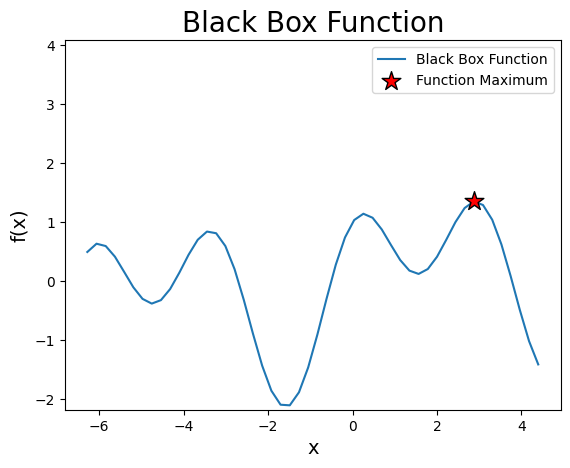

In [2]:
# Define Black-Box function. This can be changed to whatever you'd like
def black_box_function(x):
    y = np.sin(x) + np.cos(2*x) +.08*x
    return y

# Creating a range of x-values to pass into our Black-Box function
x_range = np.linspace(-2*np.pi, 1.4*np.pi, 50)

# Black-Box function output at each x-value
black_box_output = black_box_function(x_range)

# Find the max value in the Black-Box fuction. This is strictly for reference
# and will be the point we are going to seek using our AL approach.
max_point_y = np.max(black_box_output)
max_point_x = x_range[np.argmax(black_box_output)]

# Plot the black box function and maximum
plt.plot(x_range, black_box_output,zorder=0)
plt.scatter(max_point_x,max_point_y,color='r',marker='*',edgecolor='black',linewidth=1,s=200,zorder=1)
plt.legend(['Black Box Function','Function Maximum'])
plt.xlabel('x', fontsize=14)
plt.ylabel('f(x)', fontsize=14)
plt.title('Black Box Function', fontsize=20)
plt.ylim(-2.176158772646775,4.088110820199165)
plt.show()

#### 1.2 - "Seeding" Points to learn from
While active learning is all about using information we have available to inform the next point / experiment, we need to start somewhere. In this example, we will start with seeding or "revealing" 5 random points of the function. So while we know what the function looks like as a whole, the downstream ML model will not and will need to infer from the datapoints.

> **Note:** Notice how when you remove the Black-Box function (plot on the right) and only look at the sample points, your interpretation of the relationship between x and f(x) is very different. One could easily interperet the relationship as linear perhaps, not complex like the true function. This is an important point. Your data informs your model. It may start out with the wrong belief of the system depending on the seeding data. This is why we will iterate over time to improve.

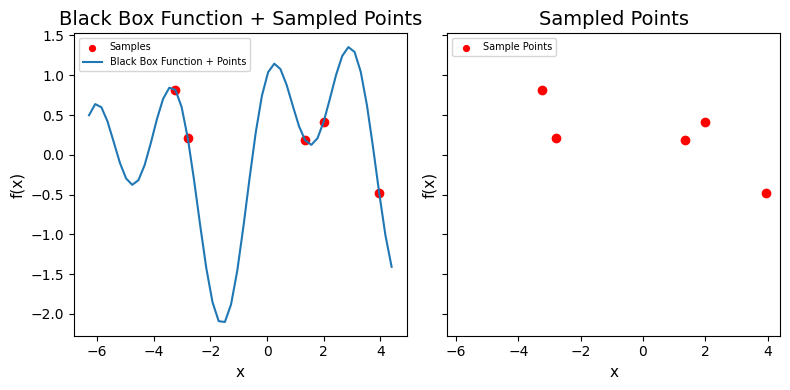

In [3]:
# Setting a numpy seed so that the results are always reproducible every time we
# run the code
np.random.seed(5)

# Random x-values to sample
num_samples = 5
sample_x = np.random.choice(x_range, size=num_samples)

# Output for each sampled x-value
sample_y = black_box_function(sample_x)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(8, 4),sharey=True)

# Plotting the samples overlayed on the black box function
axs[0].scatter(sample_x, sample_y, color='r', label="Samples")
axs[0].plot(x_range, black_box_output, label="Black Box Function + Points")
axs[0].set_title('Black Box Function + Sampled Points', fontsize=14)
axs[0].set_xlabel('x', fontsize=11)
axs[0].set_ylabel('f(x)', fontsize=11)
axs[0].legend(loc='upper left', fontsize=7, markerscale=0.7)

# Plotting the samples on the second subplot
axs[1].scatter(sample_x, sample_y, color='r', label="Sample Points")
axs[1].set_title('Sampled Points', fontsize=14)
axs[1].set_xlabel('x', fontsize=11)
axs[1].set_ylabel('f(x)', fontsize=11)
axs[1].legend(loc='upper left', fontsize=7, markerscale=0.7)
axs[1].set_xlim([-2*np.pi, 1.4*np.pi])
plt.tight_layout()
plt.show()


#### 1.3 - Training a Gaussian Process Regressor
One of the most common models in BO or AL is the GPR. The reason for this is because its a probabilistic model that uses a variety of gaussian priors to update itself and comes to a statistical belief or prediction based on data. Both a prediction (mean) and uncertainty (standard deviation) form the basis for AL and what we call the explore / exploit trade-off.

Here we will train a GPR model and show both its predictions across the function space, but also its uncertainty. Note that the model after training  does not have a great representation of the true Black-Box function. Also, you can see that the model has various levels of certainty across the x-axis. Near the points that it has seen, it is more confident (smaller standard deviation) than areas far away from revealed points. This behavior becomes very important when working with the explore / exploit trade-off.

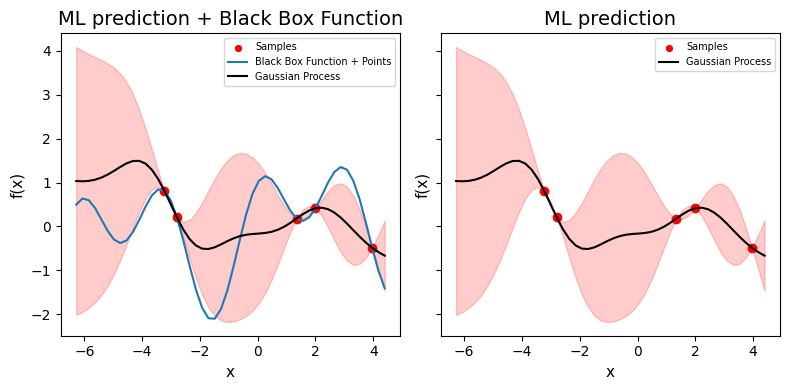

In [4]:
# Gaussian process regressor with an RBF kernel - For more information on
# kernels and GPR models, you can visit Sci-Kit learn
kernel = RBF(length_scale=.10)+DotProduct()
gp_model = GaussianProcessRegressor(kernel=kernel)

# Fit the GPR model to the sampled points
# Important: model is only getting access to our sampled points
# If you are wondering about cross-validation and hyperparameters, note that is
# still important, but not the topic here.
gp_model.fit(sample_x.reshape(-1, 1), sample_y)

# Generate predictions using GPR - here we are predicting all possible x-values.
# For a more complicated problem, this would be similar to passing possible
# enzyme assay or polymer composition combinations.
y_pred, y_std = gp_model.predict(x_range.reshape(-1, 1), return_std=True)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(8, 4),sharey=True)


# Plotting the samples overlayed on the black box function
axs[0].scatter(sample_x, sample_y, color='r', label="Samples")
axs[0].plot(x_range, black_box_output, label="Black Box Function + Points")
axs[0].plot(x_range, y_pred, color='black', label='Gaussian Process')
axs[0].fill_between(x_range, y_pred - 2*y_std, y_pred + 2*y_std, color='red', alpha=0.2)
axs[0].set_title('ML prediction + Black Box Function', fontsize=14)
axs[0].set_xlabel('x', fontsize=11)
axs[0].set_ylabel('f(x)', fontsize=11)
axs[0].legend(loc='upper right', fontsize=7, markerscale=0.7)

# Plotting the samples on the second subplot
axs[1].scatter(sample_x, sample_y, color='red', label='Samples')
axs[1].plot(x_range, y_pred, color='black', label='Gaussian Process')
axs[1].fill_between(x_range, y_pred - 2*y_std, y_pred + 2*y_std, color='red', alpha=0.2)
axs[1].set_title('ML prediction', fontsize=14)
axs[1].set_xlabel('x', fontsize=11)
axs[1].set_ylabel('f(x)', fontsize=11)
axs[1].legend(loc='upper right', fontsize=7, markerscale=0.7)
plt.tight_layout()
plt.show()

#### 1.4 - The Expected Improvement Function - An "Acquisition Function"
In AL you will run across the term acquisition function a lot. This is some function that we use to decide / quantify the value of an unknown point. In this example, we will use the expected improvement function which is probably the most common acquisition function used. There are many different functions out there, including but not limited to probability of improvement (PI) and lower confidence bound (LCB), which will be discussed in tutorial notebook 2.

The expected improvement function (EI) considers the probability that we will improve upon our previous data points (find a better max) while also weighing the size/magnitude of that improvement.

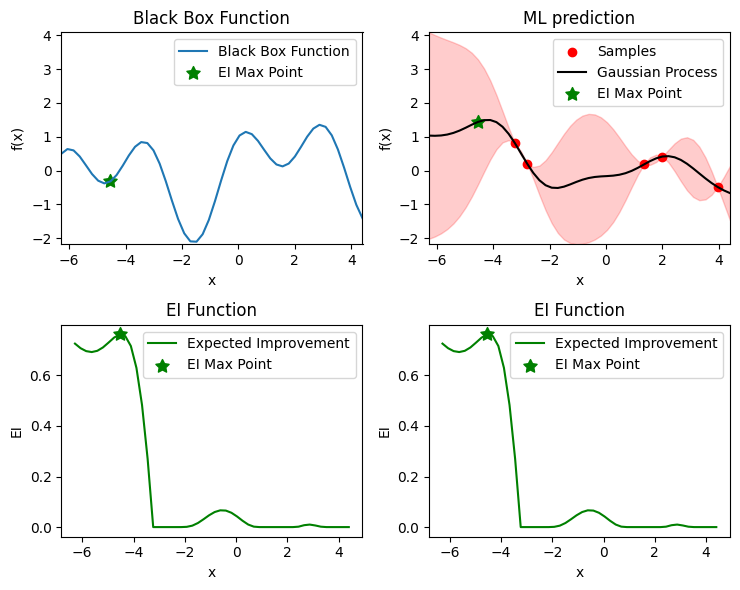

In [5]:
# Here we define the expected improvement function which is a non-dimensional
# quantity that we base the "value" of a point on. Basically we will pick the
# point with the highest EI as our next experiment or the next point to reveal.

def expected_improvement(x, gp_model, best_y):
    y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True)
    z = (y_pred - best_y) / y_std
    ei = (y_pred - best_y) * norm.cdf(z) + y_std * norm.pdf(z)
    return ei

# Determine the point with the highest observed function value
best_idx = np.argmax(sample_y)
best_x = sample_x[best_idx]
best_y = sample_y[best_idx]

# Calculating an array of expected improvement for each point
ei = expected_improvement(x_range, gp_model, best_y)

# Finding the x-value at which the expected improvement is the greatest.
ei_idx = x_range[np.argmax(ei)]
ei_max = np.max(ei)

# Plotting

# Set common y, calculate from all values used across plots
y_all = np.concatenate([black_box_output, sample_y, y_pred - 2*y_std, y_pred + 2*y_std,])

y_min = y_all.min()
y_max = y_all.max()

# Initialize subplot and figure size
fig, axs = plt.subplots(2, 2, figsize=(7.5, 6),sharey=False)

# Plotting the black box function on the first subplot (top left)
axs[0,0].plot(x_range, black_box_output, label="Black Box Function")
axs[0,0].scatter(ei_idx,black_box_output[np.argmax(ei)],color='green',marker=(5,1),s=100,label='EI Max Point')
axs[0,0].set_title('Black Box Function')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('f(x)')
axs[0,0].set_xlim(min(x_range), max(x_range))
axs[0,0].set_ylim(y_min, y_max)
axs[0,0].legend(loc='upper right')

# Plotting the samples on the second subplot (top right)
axs[0,1].scatter(sample_x, sample_y, color='red', label='Samples')
axs[0,1].plot(x_range, y_pred, color='black', label='Gaussian Process')
axs[0,1].fill_between(x_range, y_pred - 2*y_std, y_pred + 2*y_std, color='red', alpha=0.2)
axs[0,1].scatter(ei_idx,y_pred[np.argmax(ei)],color='green',marker=(5,1),s=100,label='EI Max Point')
axs[0,1].set_title('ML prediction')
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('f(x)')
axs[0,1].set_xlim(min(x_range), max(x_range))
axs[0,1].set_ylim(y_min, y_max)
axs[0,1].legend(loc='upper right')

# Plot the expected improvement
for ax in axs[1]:
    ax.plot(x_range, ei, color='green', label='Expected Improvement')
    ax.scatter(ei_idx, ei[np.argmax(ei)], color='green', marker=(5, 1), s=100, label='EI Max Point')
    ax.set_title('EI Function')
    ax.set_xlabel('x')
    ax.set_ylabel('EI')
    ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


<b>Graph Breakdown:</b>

Here, we have plotted the Black-Box function, the ML model's predictions across space, and the new EI function (green). By plotting the expected improvement function, we can see where the acquistion function thinks the highest value / gain is based on the ML models predictions and confidence in those predictions. Note how the EI function is very high in an area that has a high prediction from the model and only a little variance, and the other two increases are at areas with lower predicted values, but higher variance. This is because EI is what we call "greedy", i.e it favors a better prediction over areas with variance. However, if the predictions are near equal, then extra variance will win out.

> **Note:** When we overlay this expected point on our Black-Box function which is what we really seek the maximum of, we realize that this isn't a great point. However, there is no way for the model to know this ahead of time and is the reality of this adaptive sampling. In the next part we will reveal the point, update the model, and redo the EI calculation.

#### 1.5 - Doing the "Experiment" and Updating our Model
To proceed from here, we effectively take the point identified by the EI function as our "next experiment". In the instance of this example, we will reveal the real value for the point and use it to update the model. In the case of real lab experiments, this would be the point at which new formulations would be identified to go try and collect assay / characterization data on.

Once the data is collected, the model is re-updated, and we re-calculate the EI function again. Here, we will look at how the ML model adapts to the new data, as well as how the area that the EI function thought was highly beneficial before changes based on this update.

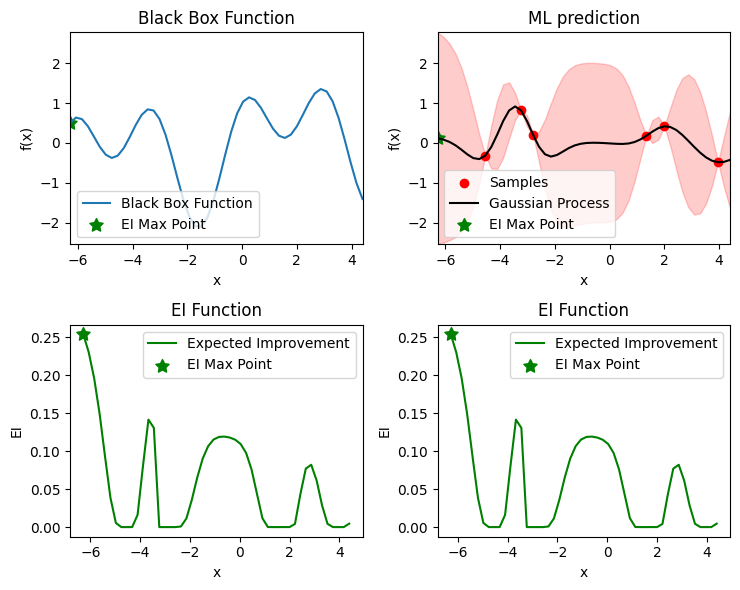

In [6]:
# Here I am grabbing the values of the new point (x,y) and then appending them
# to the x_samples and y_samples that were defined before.
new_x_point = ei_idx
new_y_point = black_box_output[np.argmax(ei)]

# Appending these new points to create a new sample array. Using i2 = iteration #2
sample_x_i2 = np.append(sample_x,new_x_point)
sample_y_i2 = np.append(sample_y,new_y_point)


# Gaussian process regressor with an RBF kernel - For more information on
# kernels and GPR models, you can visit Sci-Kit learn.
gp_model = GaussianProcessRegressor(kernel=kernel)

# Fit the Gaussian process model to the sampled points - Important: model is
# only getting access to our sampled points.
# If you are wondering about cross-validation and hyperparameters, note that
# is still important, but not the topic here.
gp_model.fit(sample_x_i2.reshape(-1, 1), sample_y_i2)

# Generate predictions using the Gaussian process model - here we are passing in
# all the possible x-values. For a more complicated problem, this would be
# similar to passing polymer compositions for exmaple
y_pred, y_std = gp_model.predict(x_range.reshape(-1, 1), return_std=True)

# Determine the point with the highest observed function value
best_idx = np.argmax(sample_y_i2)
best_x = sample_x_i2[best_idx]
best_y = sample_y_i2[best_idx]

# Calculating an array of expected improvement values for each point
ei = expected_improvement(x_range, gp_model, best_y)

# finding the x-value at which the expected improvement is the greatest.
ei_idx = x_range[np.argmax(ei)]
ei_max = np.max(ei)

# Set common y, calculate from all values used across plots
y_all = np.concatenate([black_box_output, sample_y, y_pred - 2*y_std, y_pred + 2*y_std,])

y_min = y_all.min()
y_max = y_all.max()

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(7.5, 6),sharey=False)

# Plotting the black box function on the first subplot
axs[0,0].plot(x_range, black_box_output, label="Black Box Function")
axs[0,0].scatter(ei_idx,black_box_output[np.argmax(ei)],color='green',marker=(5,1),s=100,label='EI Max Point')
axs[0,0].set_title('Black Box Function')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('f(x)')
axs[0,0].set_xlim(min(x_range), max(x_range))
axs[0,0].set_ylim(y_min, y_max)
axs[0,0].legend(loc='lower left')

# Plotting the samples on the second subplot
axs[0,1].scatter(sample_x_i2, sample_y_i2, color='red', label='Samples')
axs[0,1].plot(x_range, y_pred, color='black', label='Gaussian Process')
axs[0,1].fill_between(x_range, y_pred - 2*y_std, y_pred + 2*y_std, color='red', alpha=0.2)
axs[0,1].scatter(ei_idx,y_pred[np.argmax(ei)],color='green',marker=(5,1),s=100,label='EI Max Point')
axs[0,1].set_title('ML prediction')
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('f(x)')
axs[0,1].set_xlim(min(x_range), max(x_range))
axs[0,1].set_ylim(y_min, y_max)
axs[0,1].legend(loc='lower left')

# Plot the expected improvement
for ax in axs[1]:
    ax.plot(x_range, ei, color='green', label='Expected Improvement')
    ax.scatter(ei_idx,ei[np.argmax(ei)],color='green',marker=(5,1),s=100,label='EI Max Point')
    ax.set_title('EI Function')
    ax.set_xlabel('x')
    ax.set_ylabel('EI')
    ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


<b> Graph Breakdown:</b>
Notice how much the ML Belief changes and how much uncertainty has been added into the model with this new updated point. Also note how the EI changes as we have significantly more variance / uncertainty in the models predictions. Now there are a lot of x-values with relatively high EI.

#### 1.6 - Full Active Learning - Looping the Pipeline
Now to achieve full active learning, we run this pipeline until we come upon our function maximium. We will generate a loop that reveals the previous identified max EI point to the model, update the model, and recalculate the EI again to determine the next virtual experiment. Eventually this will converge upon our global maximum for the function.

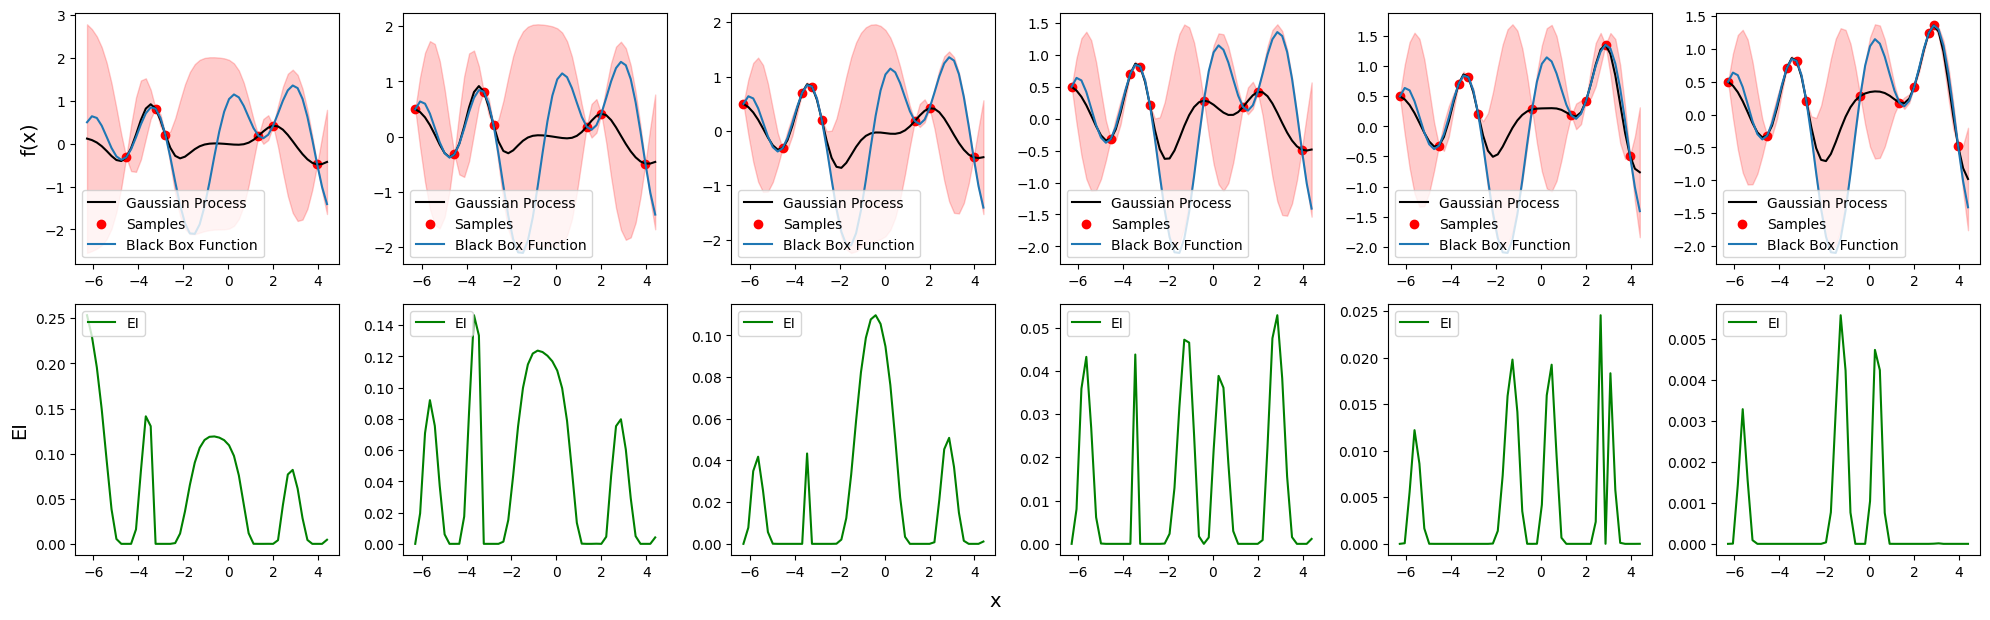

In [7]:
# Creating new variables so they can be standalone
sample_x_loop = sample_x_i2
sample_y_loop = sample_y_i2


# Range of x-values - creating a range of x-values to pass into our black box
# function
x_range_loop = np.linspace(-2*np.pi, 1.4*np.pi, 50)


# Plotting
fig, axs = plt.subplots(2,6, figsize=(20, 6),sharey=False)


for n in range(0,6):

    ### Step 1 - Updating our model to reflect our current pool of data and
    # generating predictions about the space. ###

    gp_model = GaussianProcessRegressor(kernel=kernel)
    gp_model.fit(sample_x_loop.reshape(-1, 1), sample_y_loop)
    y_pred, y_std = gp_model.predict(x_range_loop.reshape(-1, 1),
                                     return_std=True)

    ### Step 2 - Calculating the Expected Improvement across the predictions ###

    # Determine the point with the highest observed function value
    best_idx = np.argmax(sample_y_loop)
    best_x = sample_x_loop[best_idx]
    best_y = sample_y_loop[best_idx]
    # Calculating an array of expected improvement for each point
    ei = expected_improvement(x_range_loop, gp_model, best_y)

    ### Step 3 - Plotting the current scenario ###
    axs[0,n].plot(x_range, y_pred, color='black', label='Gaussian Process')
    axs[0,n].scatter(sample_x_loop,sample_y_loop, color='red', label='Samples')
    axs[0,n].plot(x_range,black_box_output,label='Black Box Function')
    axs[0,n].fill_between(x_range, y_pred - 2*y_std, y_pred + 2*y_std,
                          color='red', alpha=0.2)
    axs[0,n].legend(loc='lower left')

    axs[1,n].plot(x_range, ei, color='green', label='EI')
    axs[1,n].legend(loc='upper left')


    ### Step 4 - Updating our data with the new identified point
    # finding the x-value at which the expected improvement is the greatest. ###
    ei_idx = x_range_loop[np.argmax(ei)]
    ei_max = np.max(ei)

    new_x_point = ei_idx
    new_y_point = black_box_output[np.argmax(ei)]

    sample_x_loop = np.append(sample_x_loop,new_x_point)
    sample_y_loop = np.append(sample_y_loop,new_y_point)

# Add plot labels
axs[0, 0].set_ylabel('f(x)', fontsize=14)
axs[1, 0].set_ylabel('EI', fontsize=14)
fig.text(0.5, -0.02, 'x', ha='center', fontsize=14)

plt.tight_layout()
plt.show()

**Graph Breakdown:**
During this simulated active learning campaign, you should notice how after each iteration, the expected improvement values decrease drastically. Due to a relativly simple Black-Box function this is to be expected. Initially with a relatively sparse sampling of the design space, additional values will have greater theoretical impact on the model. However, even in iterations with low expected improvement values, additional iterations should not be ignored, as the value is not a true representation of model improvement. Information on concluding an AL campaign will be discussed in notebook 3.

#### Notebook 1 Summary

In this notebook, we Introduced a one dimentional Black box function of sines and cosines to explore BO based on using a GPR as an ML model. We explained the procedure to train this ML model based on a seeded design space. We then introduced the application of an EI acquisition functinon that utilized the outputs of the trained model to generate predictions on which new sample would improve the model the most. Finally, we discussed how to use the processes of BO to effectivly iterate model training within a loop to understand the design space to find the maximum value of the function. Currently, you should have a baseline confortablility with the concepts discussed. However, we encourage you to check out the next two Colabs where we add further complexity in the form of alternative methods and higher dimensional problems.  